#POS himself

In [ ]:
import sys
import numpy as np

class PSO:

    def __init__(self, particles, velocities, fitness_function,
                 w=0.8, c_1=1, c_2=1, max_iter=320, auto_coef=True):
        self.particles = particles
        self.velocities = velocities
        self.fitness_function = fitness_function

        self.N = len(self.particles)
        self.w = w
        self.c_1 = c_1
        self.c_2 = c_2
        self.auto_coef = auto_coef
        self.max_iter = max_iter


        self.p_bests = self.particles
        self.p_bests_values = self.fitness_function(self.particles)
        self.g_best = self.p_bests[0]
        self.g_best_value = self.p_bests_values[0]
        self.update_bests()

        self.iter = 0
        self.is_running = True
        self.update_coef()

    def __str__(self):
        return f'[{self.iter}/{self.max_iter}] $w$:{self.w:.3f} - $c_1$:{self.c_1:.3f} - $c_2$:{self.c_2:.3f}'

    def next(self):
        if self.iter > 0:
            self.move_particles()
            self.update_bests()
            self.update_coef()

        self.iter += 1
        self.is_running = self.is_running and self.iter < self.max_iter
        return self.is_running

    def update_coef(self):
        if self.auto_coef:
            t = self.iter
            n = self.max_iter
            self.w = (0.4/n**2) * (t - n) ** 2 + 0.4
            self.c_1 = -3 * t / n + 3.5
            self.c_2 =  3 * t / n + 0.5

    def move_particles(self):

        # add inertia
        new_velocities = self.w * self.velocities
        # add cognitive component
        r_1 = np.random.random(self.N)
        r_1 = np.tile(r_1[:, None], (1, 2))
        new_velocities += self.c_1 * r_1 * (self.p_bests - self.particles)
        # add social component
        r_2 = np.random.random(self.N)
        r_2 = np.tile(r_2[:, None], (1, 2))
        g_best = np.tile(self.g_best[None], (self.N, 1))
        new_velocities += self.c_2 * r_2 * (g_best  - self.particles)

        self.is_running = np.sum(self.velocities - new_velocities) != 0

        # update positions and velocities
        self.velocities = new_velocities
        self.particles = self.particles + new_velocities


    def update_bests(self):
        fits = self.fitness_function(self.particles)

        for i in range(len(self.particles)):
            # update best personnal value (cognitive)
            if fits[i] < self.p_bests_values[i]:
                self.p_bests_values[i] = fits[i]
                self.p_bests[i] = self.particles[i]
                # update best global value (social)
                if fits[i] < self.g_best_value:
                    self.g_best_value = fits[i]
                    self.g_best = self.particles[i]

#Utils

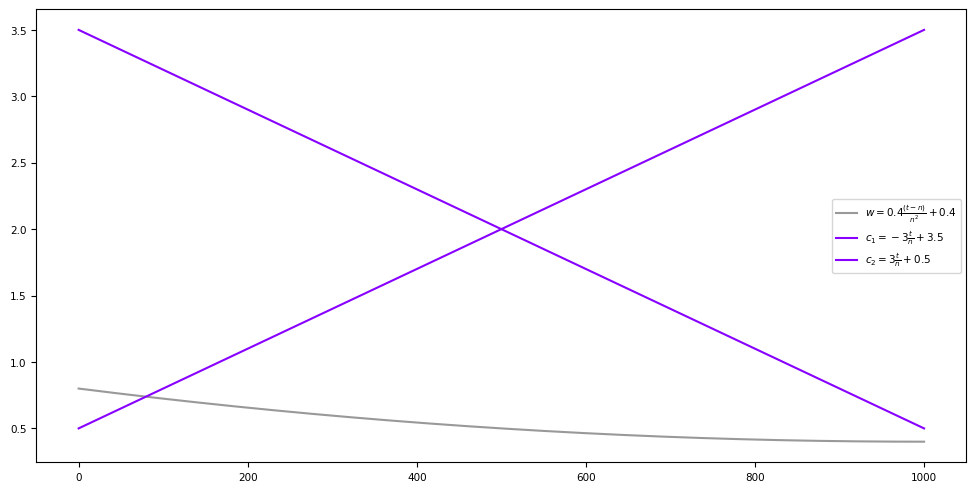

In [ ]:
import os
import glob
import shutil

import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter




def make_gif_from_folder(folder, out_file_path, remove_folder=True):
    files = os.path.join(folder, '*.png')
    img, *imgs = [Image.open(f) for f in sorted(glob.glob(files))]
    img.save(fp=out_file_path, format='GIF', append_images=imgs,
             save_all=True, duration=200, loop=0)
    shutil.rmtree(folder, ignore_errors=True)



plt.rcParams['figure.figsize'] = [12, 6] # default = [6.0, 4.0]
plt.rcParams['figure.dpi']     = 100     # default = 72.0
plt.rcParams['font.size']      = 7.5     # default = 10.0

cmap = cm.colors.LinearSegmentedColormap.from_list('Custom',
                                                   [(0, '#2f9599'),
                                                    (0.45, '#eee'),
                                                    (1, '#8800ff')], N=256)


def plot_2d_pso(meshgrid, function, particles=None, velocity=None, normalize=True, color='#000', ax=None):
    X_grid, Y_grid = meshgrid
    Z_grid = function(X_grid, Y_grid)
    # get coordinates and velocity arrays
    if particles is not None:
        X, Y = particles.swapaxes(0, 1)
        Z = function(X, Y)
        if velocity is not None:
            U, V = velocity.swapaxes(0, 1)
            if normalize:
                N = np.sqrt(U**2+V**2)
                U, V = U/N, V/N

    # create new ax if None
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1, projection='3d')

    # add contours and contours lines
    ax.contour(X_grid, Y_grid, Z_grid, levels=30, linewidths=0.5, colors='#999')
    cntr = ax.contourf(X_grid, Y_grid, Z_grid, levels=30, cmap=cmap, alpha=0.7)
    if particles is not None:
        ax.scatter(X, Y, color=color)
        if velocity is not None:
            ax.quiver(X, Y, U, V, color=color, headwidth=2, headlength=2, width=5e-3)

    # add labels and set equal aspect ratio
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_xlim(np.min(X_grid), np.max(X_grid))
    ax.set_ylim(np.min(Y_grid), np.max(Y_grid))
    ax.set_aspect(aspect='equal')


def plot_3d_pso(meshgrid, function, particles=None, velocity=None, normalize=True, color='#000', ax=None):
    X_grid, Y_grid = meshgrid
    Z_grid = function(X_grid, Y_grid)
    # get coordinates and velocity arrays
    if particles is not None:
        X, Y = particles.swapaxes(0, 1)
        Z = function(X, Y)
        if velocity is not None:
            U, V = velocity.swapaxes(0, 1)
            W = function(X + U, Y + V) - Z

    # create new ax if None
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1, projection='3d')

    # Plot the surface.
    surf = ax.plot_surface(X_grid, Y_grid, Z_grid, cmap=cmap,
                           linewidth=0, antialiased=True, alpha=0.7)
    ax.contour(X_grid, Y_grid, Z_grid, zdir='z', offset=0, levels=30, cmap=cmap)
    if particles is not None:
        ax.scatter(X, Y, Z, color=color, depthshade=True)
        if velocity is not None:
            ax.quiver(X, Y, Z, U, V, W, color=color, arrow_length_ratio=0., normalize=normalize)

    len_space = 10
    # Customize the axis
    max_z = (np.max(Z_grid) // len_space + 1).astype(np.int) * len_space
    ax.set_xlim3d(np.min(X_grid), np.max(X_grid))
    ax.set_ylim3d(np.min(Y_grid), np.max(Y_grid))
    ax.set_zlim3d(0, max_z)
    ax.zaxis.set_major_locator(LinearLocator(max_z // len_space + 1))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    # Rmove fills and set labels
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('f(X, Y)')

    # Add a color bar which maps values to colors.
    # fig.colorbar(surf)


if __name__ == '__main__':
    N = 1000
    t = np.arange(0, N + 1)
    w = (0.4 / N**2) * (t - N) ** 2 + 0.4
    c_1 = -3 * t / N + 3.5
    c_2 =  3 * t / N + 0.5

    plt.plot(t, w, color='#999', label=r'$w = 0.4\frac{(t - n)}{n^2} + 0.4$')
    plt.plot(t, c_1, color='#80f', label=r'$c_1 = -3\frac{t}{n} + 3.5$')
    plt.plot(t, c_2, color='#80f', label=r'$c_2 = 3\frac{t}{n} + 0.5$')
    plt.legend()
    plt.show()

#Plot init

/usr/local/lib/python3.8/dist-packages/mpl_toolkits/mplot3d/art3d.py:304: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self._segments3d = np.asanyarray(segments)
<ipython-input-2-02cbe1ad00c7>:96: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  max_z = (np.max(Z_grid) // len_space + 1).astype(np.int) * len_space
<ipython-input-2-

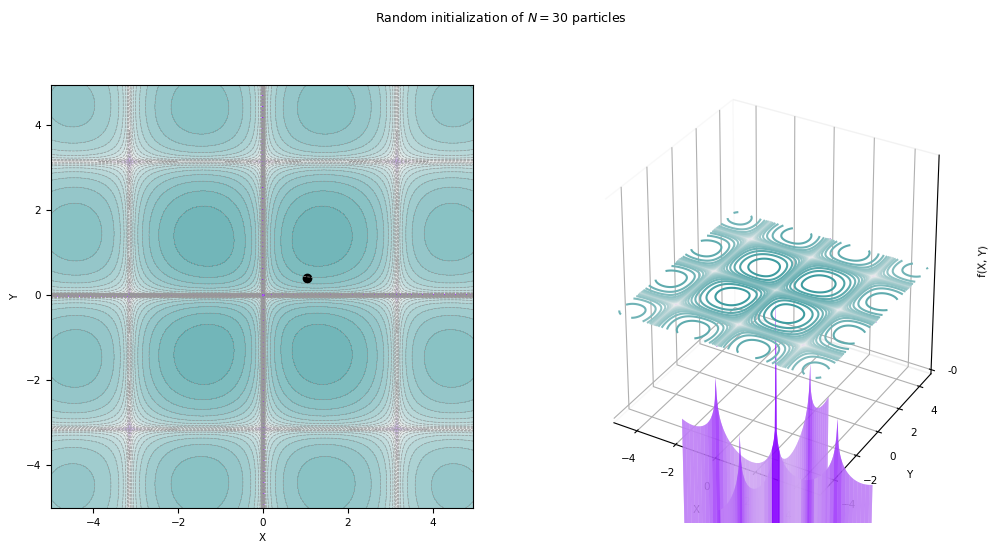

In [5]:
import numpy as np
import matplotlib.pyplot as plt

#from utils import plot_2d_pso, plot_3d_pso

n_particles = 1

# Make range grid
X = np.arange(-5, 5, 0.05)
Y = np.arange(-5, 5, 0.05)
meshgrid = np.meshgrid(X, Y)
f = lambda x, y: -0.0001 * (np.fabs(np.sin(x) * np.sin(y) * np.exp(np.fabs(100 - (np.sqrt((x ** 2) + (y ** 2)) / np.pi)))) + 1) ** 0.1
particles = np.random.uniform(-5, 5, (n_particles, 2))
velocity = None
save_path = '0_particle.png'
# save_path = None

fig = plt.figure()
ax = fig.add_subplot(1, 2, 2, projection='3d')
plot_3d_pso(meshgrid, f, particles, velocity, ax=ax)
ax = fig.add_subplot(1, 2, 1)
plot_2d_pso(meshgrid, f, particles, velocity, ax=ax)
fig.suptitle(r'Random initialization of $N=30$ particles')


if save_path is not None:
    plt.savefig(save_path)
else:
    plt.show()

#Plot run

<ipython-input-6-16b000f3505f>:16: RuntimeWarning: overflow encountered in exp
  f = lambda x, y: -0.0001 * (np.fabs(np.sin(x) * np.sin(y) * np.exp(np.fabs(100 - (np.sqrt((x ** 2) + (y ** 2)) / np.pi)))) + 1) ** 0.1
<ipython-input-2-02cbe1ad00c7>:46: RuntimeWarning: divide by zero encountered in true_divide
  U, V = U/N, V/N
<ipython-input-2-02cbe1ad00c7>:46: RuntimeWarning: invalid value encountered in true_divide
  U, V = U/N, V/N


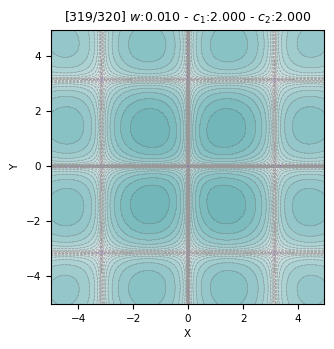

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt

# from PSO import PSO
# from utils import plot_2d_pso, plot_3d_pso, make_gif_from_folder

n_particles = 250

# Make range grid
X = np.arange(-5, 5, 0.05)
Y = np.arange(-5, 5, 0.05)
meshgrid = np.meshgrid(X, Y)


f = lambda x, y: -0.0001 * (np.fabs(np.sin(x) * np.sin(y) * np.exp(np.fabs(100 - (np.sqrt((x ** 2) + (y ** 2)) / np.pi)))) + 1) ** 0.1

def fitness_function(pos):
    x, y = pos.swapaxes(0, 1)
    return f(x, y)


particles = np.random.uniform(-5, 5, (n_particles, 2))
velocities = (np.random.random((n_particles, 2)) - 0.5) / 10

pso_1 = PSO(particles.copy(), velocities.copy(), fitness_function, w=0.01, c_1=2.0, c_2=2.0, auto_coef=False)
pso_2 = PSO(particles.copy(), velocities.copy(), fitness_function, w=0.1, c_1=4.0, c_2=0.0, auto_coef=False)
pso_3 = PSO(particles.copy(), velocities.copy(), fitness_function, w=0.1, c_1=4.0, c_2=0.0, auto_coef=False)


root = 'src/'
filename = '_tmp.gif'
save = True

if save:
    tmp_dir = os.path.join(root, '_tmp')
    if not os.path.exists(tmp_dir):
        os.makedirs(tmp_dir)

fig = plt.figure()

while pso_1.next():
    # pso_2.next()
    # pso_3.next()
    fig.clear()
    save_path = None if not save else os.path.join(tmp_dir, f'{pso_1.iter:05d}.png')

    # ax = fig.add_subplot(1, 2, 2, projection='3d')
    # plot_3d_pso(meshgrid, f, pso.particles, pso.velocities, ax=ax)
    ax = fig.add_subplot(1, 3, 1)
    plot_2d_pso(meshgrid, f, pso_1.particles, pso_1.velocities, ax=ax)
    ax.set_title(str(pso_1))

    # ax = fig.add_subplot(1, 3, 2)
    # plot_2d_pso(meshgrid, f, pso_2.particles, pso_2.velocities, ax=ax)
    # ax.set_title(str(pso_2))

    # ax = fig.add_subplot(1, 3, 3)
    # plot_2d_pso(meshgrid, f, pso_3.particles, pso_3.velocities, ax=ax)
    # ax.set_title(str(pso_3))


    if save_path is None:
        plt.show()
    else:
        plt.savefig(save_path)

make_gif_from_folder(tmp_dir, os.path.join(root, filename))